In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import torch
from torch import nn as nn
from math import factorial
import random
import torch.nn.functional as F
import numpy as np
import seaborn as sn
import pandas as pd
import os 
from os.path import join
import glob
from math import factorial
ttype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
ctype = torch.cuda.LongTensor if torch.cuda.is_available() else torch.LongTensor
print(ttype)
from torch.nn.utils import weight_norm
from deepsith import DeepSITH
from tqdm.notebook import tqdm
import pickle
sn.set_context("poster")
import itertools
from csv import DictWriter

<class 'torch.cuda.FloatTensor'>


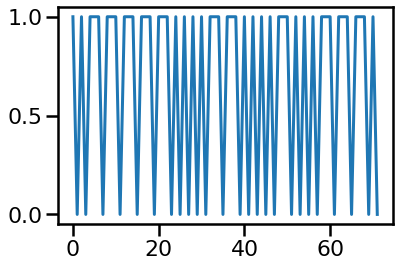

In [3]:
def generate_noise():
    """Generates dot and dash based noise."""
    
    threes = np.random.randint(8, 14)
    ones = (18 - threes) * 2
    noise = list(itertools.repeat([1,1,1,0], threes))
    noise.extend(list(itertools.repeat([1,0], ones)))
    random.shuffle(noise)
    noise = np.concatenate(noise)
    return noise
noise = generate_noise()
plt.plot(noise)


In [4]:
sig_lets = ["A","B","C","D","E","F","G","H",]

signals = ttype([[0,1,1,1,0,1,1,1,0,1,0,1,0,1,0,0,0],
                 [0,1,1,1,0,1,0,1,1,1,0,1,0,1,0,0,0],
                 [0,1,1,1,0,1,0,1,0,1,1,1,0,1,0,0,0],
                 [0,1,1,1,0,1,0,1,0,1,0,1,1,1,0,0,0],
                 [0,1,0,1,1,1,0,1,1,1,0,1,1,1,0,0,0],
                 [0,1,1,1,0,1,0,1,1,1,0,1,1,1,0,0,0],
                 [0,1,1,1,0,1,1,1,0,1,0,1,1,1,0,0,0],
                 [0,1,1,1,0,1,1,1,0,1,1,1,0,1,0,0,0]]
               ).view(8, 1, 1, -1)
#signals = ms
key2id = {k:i for i, k in enumerate(sig_lets)}

print(key2id)


{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7}


In [5]:
torch.manual_seed(12345)
training_samples = 50

training_signals = []
training_class = []

for i, sig in enumerate(signals):
    temp_signals = []
    temp_class = []
    for x in range(training_samples):
        noise = ttype(generate_noise())
        temp = torch.cat([sig[0,0], noise]).unsqueeze(0).unsqueeze(0).unsqueeze(0)
        while(any([(temp == c_).all() for c_ in temp_signals])):
            print('SHIT')
            noise = ttype(generate_noise())
            temp = torch.cat([sig[0,0], noise]).unsqueeze(0).unsqueeze(0).unsqueeze(0)
        temp_signals.append(temp)
        temp_class.append(i)
    training_signals.extend(temp_signals)
    training_class.extend(temp_class)

batch_rand = torch.randperm(training_samples*signals.shape[0])        
training_signals = torch.cat(training_signals)[batch_rand]
training_class  = ctype(training_class)[batch_rand]

print(training_signals.shape, training_class.shape)

torch.Size([400, 1, 1, 89]) torch.Size([400])


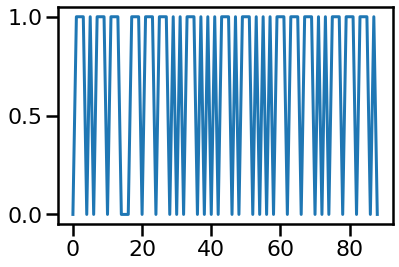

In [6]:
plt.plot(training_signals[0,0,0].detach().cpu())

In [7]:
testing_samples = 10
testing_signals = []
testing_class = []

for i, sig in enumerate(signals):
    temp_signals = []
    temp_class = []
    for x in range(testing_samples):
        noise = ttype(generate_noise())
        temp = torch.cat([sig[0,0], noise]).unsqueeze(0).unsqueeze(0).unsqueeze(0)
        while(any([(temp == c_).all() for c_ in temp_signals])):
            print('SHIT')
            noise = ttype(generate_noise())
            temp = torch.cat([sig[0,0], noise]).unsqueeze(0).unsqueeze(0).unsqueeze(0)
        temp_signals.append(temp)
        temp_class.append(i)
    testing_signals.extend(temp_signals)
    testing_class.extend(temp_class)
batch_rand = torch.randperm(testing_samples*signals.shape[0])

testing_signals = torch.cat(testing_signals)[batch_rand]
testing_class  = ctype(testing_class)[batch_rand]
print(testing_signals.shape, testing_class.shape)


torch.Size([80, 1, 1, 89]) torch.Size([80])


In [8]:
def train(model, ttype, train_sig, train_class, 
          test_sig, test_class, optimizer, loss_func, 
          epoch, perf_file, loss_buffer_size=20, batch_size=1, 
          device='cuda', prog_bar=None):
    assert(loss_buffer_size%batch_size==0)

    losses = []
    perfs = []
    last_test_perf = 0
    best_test_perf = -1
    for batch_idx, sig in enumerate(train_sig):
        model.train()

        target = train_class[batch_idx:batch_idx+1]
        optimizer.zero_grad()
        out = model(sig.unsqueeze(0))
        
        loss = loss_func(out[:, -1, :],
                         target)
         
        loss.backward()
        optimizer.step()
        temp = (torch.argmax(out[:, -1, :], dim=-1) == 
                      target).sum().item()
        perfs.append((torch.argmax(out[:, -1, :], dim=-1) == 
                      target).sum().item())
        perfs = perfs[int(-loss_buffer_size/batch_size):]
        losses.append(loss.detach().cpu().numpy())
        losses = losses[-loss_buffer_size:]
        if not (prog_bar is None):
            # Update progress_bar
            s = "{}:{} Loss: {:.4f}, perf: {:.4f}, valid: {:.4f}"
            format_list = [e,batch_idx*batch_size, np.mean(losses), 
                           np.sum(perfs)/((len(perfs))*batch_size), last_test_perf]         
            s = s.format(*format_list)
            prog_bar.set_description(s)
        if ((batch_idx*batch_size)%loss_buffer_size == 0) & (batch_idx != 0):
            loss_track = {}
            last_test_perf = test_norm(model, 'cuda', test_sig, test_class,
                                                batch_size=batch_size, 
                                                )
            loss_track['avg_loss'] = np.mean(losses)
            loss_track['last_test'] = last_test_perf
            loss_track['epoch'] = epoch
            loss_track['batch_idx'] = batch_idx
            loss_track['train_perf']= np.sum(perfs)/((len(perfs))*batch_size)
            with open(perf_file, 'a+') as fp:
                csv_writer = DictWriter(fp, fieldnames=list(loss_track.keys()))
                if fp.tell() == 0:
                    csv_writer.writeheader()
                csv_writer.writerow(loss_track)
            if best_test_perf <= last_test_perf:
                torch.save(model.state_dict(), perf_file[:-4]+".pt")
                best_test_perf = last_test_perf
                
def test_norm(model, device, test_sig, 
              test_class, batch_size=1):
    model.eval()
    correct = 0
    with torch.no_grad():
        out = model(test_sig)
        pred = out[:, -1].argmax(dim=-1, keepdim=True)
        correct += pred.eq(test_class.view_as(pred)).sum().item()
    return correct / test_sig.shape[0]

# Setup Classifier type model

In [9]:
class DeepSITH_Classifier(nn.Module):
    def __init__(self, out_features, layer_params, dropout=.5):
        super(DeepSITH_Classifier, self).__init__()
        last_hidden = layer_params[-1]['hidden_size']
        self.hs = DeepSITH(layer_params=layer_params, dropout=dropout)
        self.to_out = nn.Linear(last_hidden, out_features)
    def forward(self, inp):
        x = self.hs(inp)
        x = self.to_out(x)
        return x

# Training and testing

In [10]:
# You likely don't need this to be this long, but just in case.
epochs = 1000

# Just for visualizing average loss through time. 
loss_buffer_size = 100

In [11]:
sith_params1 = {"in_features":1, 
                "tau_min":1, "tau_max":5.0, 'buff_max':10,
                "k":70, 'dt':1, "ntau":8, 'g':.0,  
                "ttype":ttype, 'batch_norm':False,
                "hidden_size":20, "act_func":nn.ReLU()
               }
sith_params2 = {"in_features":sith_params1['hidden_size'], 
                "tau_min":1, "tau_max":25.0, 'buff_max':60,
                "k":15, 'dt':1, "ntau":8, 'g':.0, 
                "ttype":ttype, 'batch_norm':False,
                "hidden_size":20, "act_func":nn.ReLU()
                }
sith_params3 = {"in_features":sith_params2['hidden_size'], 
                "tau_min":1, "tau_max":125.0, 'buff_max':500,
                "k":5, 'dt':1, "ntau":8, 'g':.0, 
                "ttype":ttype, 'batch_norm':False,
                "hidden_size":20, "act_func":nn.ReLU()
                }
layer_params = [sith_params1, sith_params2, sith_params3]
model = DeepSITH_Classifier(out_features=signals.shape[0],
                            layer_params=layer_params, 
                            dropout=.0).cuda()
tot_weights = 0
for p in model.parameters():
    tot_weights += p.numel()
print("Total Weights:", tot_weights)
print(model)


Total Weights: 6788
DeepSITH_Classifier(
  (hs): DeepSITH(
    (layers): ModuleList(
      (0): _DeepSITH_core(
        (sith): iSITH(ntau=8, tau_min=1, tau_max=5.0, buff_max=10, dt=1, k=70, g=0.0)
        (linear): Linear(in_features=8, out_features=20, bias=True)
        (act_func): ReLU()
      )
      (1): _DeepSITH_core(
        (sith): iSITH(ntau=8, tau_min=1, tau_max=25.0, buff_max=60, dt=1, k=15, g=0.0)
        (linear): Linear(in_features=160, out_features=20, bias=True)
        (act_func): ReLU()
      )
      (2): _DeepSITH_core(
        (sith): iSITH(ntau=8, tau_min=1, tau_max=125.0, buff_max=500, dt=1, k=5, g=0.0)
        (linear): Linear(in_features=160, out_features=20, bias=True)
        (act_func): ReLU()
      )
    )
    (dropouts): ModuleList(
      (0): Dropout(p=0.0, inplace=False)
      (1): Dropout(p=0.0, inplace=False)
    )
  )
  (to_out): Linear(in_features=20, out_features=8, bias=True)
)


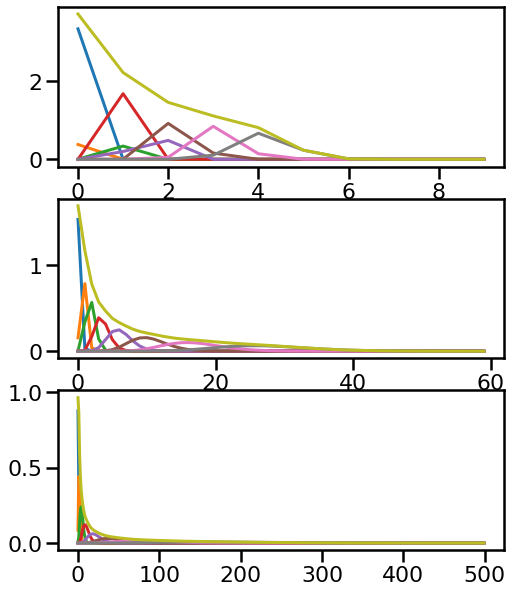

In [12]:
fig = plt.figure(figsize=(8,10))

ax = fig.add_subplot(3,1,1)
ax.plot(model.hs.layers[0].sith.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1],
       );
ax.plot(model.hs.layers[0].sith.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1].sum(1),
        );
ax = fig.add_subplot(3,1,2)
ax.plot(model.hs.layers[1].sith.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1],
        );
ax.plot(model.hs.layers[1].sith.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1].sum(1),
        );
ax = fig.add_subplot(3,1,3)
ax.plot(model.hs.layers[2].sith.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1],
        );
ax.plot(model.hs.layers[2].sith.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1].sum(1),
        );

In [13]:
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 40
batch_size = 1
progress_bar = tqdm(range(int(epochs)), bar_format='{l_bar}{bar:5}{r_bar}{bar:-5b}')
for e in progress_bar:
    train(model, ttype, training_signals, training_class, testing_signals, testing_class, 
          optimizer, loss_func, batch_size=batch_size,
          epoch=e, perf_file=join('perf','h8_deepsith_8.csv'),
          prog_bar=progress_bar)

KeyboardInterrupt: 

In [41]:
def test_norm(model, device, test_sig, 
              test_class, batch_size=1):
    model.eval()
    correct = 0
    count = 0
    with torch.no_grad():
        out = model(test_sig)
        pred = out[:, -1].argmax(dim=-1, keepdim=True)
        correct += pred.eq(test_class.view_as(pred)).sum().item()
        count += 1
    return correct / test_sig.shape[0]
test_norm(model, 'cuda', testing_signals, testing_class, batch_size=1)

0.05

In [43]:
out = model(testing_signals)

In [49]:
print(out[0, -1].argmax())
print(testing_class[0])

tensor(2, device='cuda:0')
tensor(5, device='cuda:0')


In [ ]:
with open('filename.dill', 'wb') as handle:
    pickle.dump(perf, handle, protocol=pickle.HIGHEST_PROTOCOL)

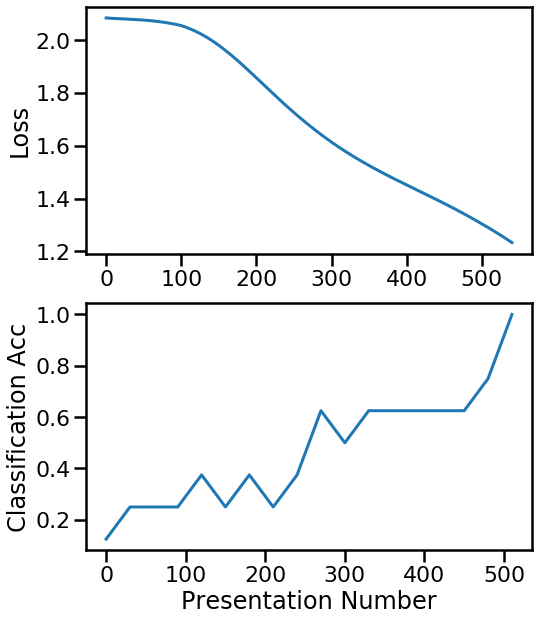

In [154]:
fig = plt.figure(figsize=(8,10))
ax = fig.add_subplot(2,1,1)
ax.plot(perfs[-1]['loss'])
ax.set_ylabel("Loss")
#ax.set_xlabel("Presentation Number")

ax = fig.add_subplot(2,1,2)
dat = pd.DataFrame(perfs[-1]['perf'])
ax.plot(np.arange(dat.shape[0])*30, dat)
ax.set_ylabel("Classification Acc")
ax.set_xlabel("Presentation Number")
()
plt.savefig(join("figs","DeepSith_training_H8"))